**MAKING PICTURES

In [45]:
from PIL import Image
import numpy as np
import IPython.display
from random import randint
from Bio import SeqIO
import math
from hilbert import HilbertCurve

fasta_file = "myco_genome.fasta"
lines_file = "genome_lines.png"
hilbert_file = "genome_hilbert.png"
mask_file = "genome_mask.png"
out_file = "genome_out_hil_mask.png"

In [46]:
#READ SEQ
for seq_record in SeqIO.parse(fasta_file, "fasta"):
    seqarray = np.asarray(seq_record.seq) 

8


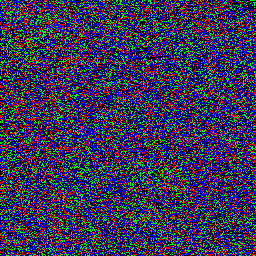

In [47]:
#PIC_HILBERT
N = 2
p = math.trunc(math.log(seqarray.size, 4)) - 3
print(p)
square = 2 ** p

length = 2 ** (N*p)
hilbert_curve = HilbertCurve(p, N)

array = np.zeros((square, square), dtype = (np.uint8, 3))

channels = {"A": 0, "T": 1, "C": 2}
# if "A" in channels:
#     print(1)

for index in range(array.size // 3):
    base = seqarray[index]
    if base in channels:
        channel = channels[base]
        coords = hilbert_curve.coordinates_from_distance(index)
        x, y = coords[0], coords[1]
        array[x][y][channel] = 255

        
new_image = Image.fromarray(array)
new_image.save(hilbert_file)
IPython.display.Image(hilbert_file)  

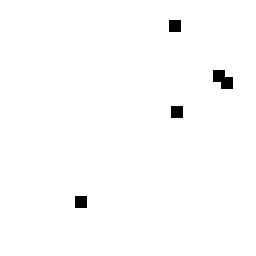

In [48]:
#MASK
mask = np.zeros((square, square), dtype=(np.uint8, 3))
number = 5
diameter = int(0.05 * square)
mask.fill(255)


# for i in range(number):
#     x = randint(0, square - diameter)
#     y = randint(0, square - diameter)
    
#     for xi in range(x, x+diameter):
#         for yi in range(y, y+diameter):
#             mask[xi][yi][0:3] = [0, 0, 0]
            
for n in range(100):
    spot = 10
    index = randint(0, lenght-spot)
    for i in range(index, index+spot):
        coords = hilbert_curve.coordinates_from_distance(i)
        x, y = coords[0], coords[1]
        mask[x, y, :] = [0,0,0]
            
            
new_image = Image.fromarray(mask)
new_image.save(mask_file)
IPython.display.Image(mask_file) 

# Deep image prior 

## Import libs 

In [49]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

## Choose figure

In [50]:
img_path  = hilbert_file
mask_path = mask_file



NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

## Load mask

In [51]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [52]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)

### Visualize

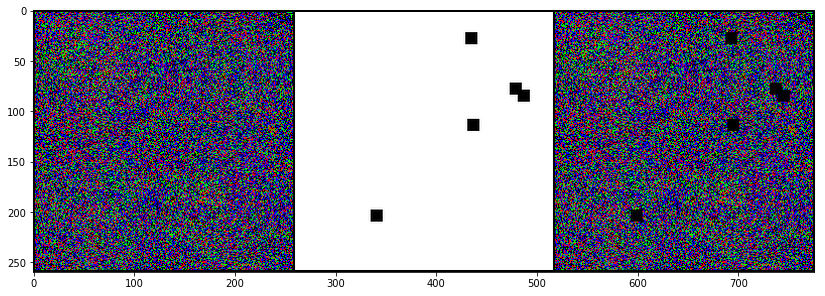

In [53]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [54]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [55]:
# if 'vase.png' in img_path:
#     INPUT = 'meshgrid'
#     input_depth = 2
#     LR = 0.01 
#     num_iter = 5001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
#     net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [128] * 5,
#                num_channels_up   = [128] * 5,
#                num_channels_skip = [0] * 5,  
#                upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
if ('kate.png' in img_path) or ('peppers.png' in img_path) or ("genome" in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = 2001
    param_noise = False
    show_every = 500
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
# elif 'library.png' in img_path:
    
#     INPUT = 'noise'
#     input_depth = 1
    
#     num_iter = 3001
#     show_every = 50
#     figsize = 8
#     reg_noise_std = 0.00
#     param_noise = True
    
#     if 'skip' in NET_TYPE:
        
#         depth = int(NET_TYPE[-1])
#         net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
#                num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
#                num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
#                filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
#                upsample_mode='nearest', # downsample_mode='avg',
#                need1x1_up=False,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
#         LR = 0.01 
        
#     elif NET_TYPE == 'UNET':
        
#         net = UNet(num_input_channels=input_depth, num_output_channels=3, 
#                    feature_scale=8, more_layers=1, 
#                    concat_x=False, upsample_mode='deconv', 
#                    pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
#         LR = 0.001
#         param_noise = False
        
#     elif NET_TYPE == 'ResNet':
        
#         net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
#         LR = 0.001
#         param_noise = False
        
#     else:
#         assert False
# else:
#     assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [56]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


# Main loop

Starting optimization with ADAM


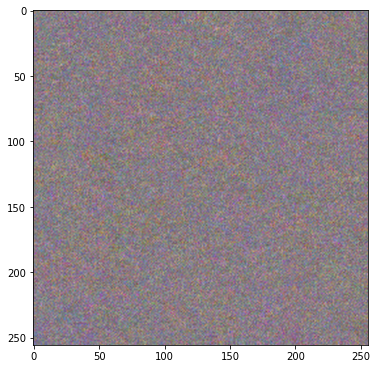

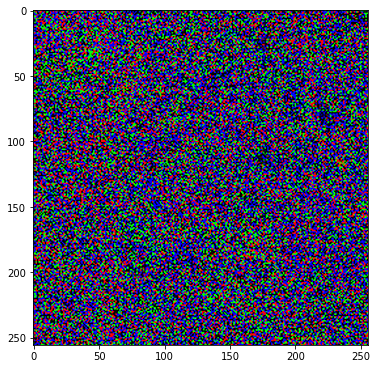

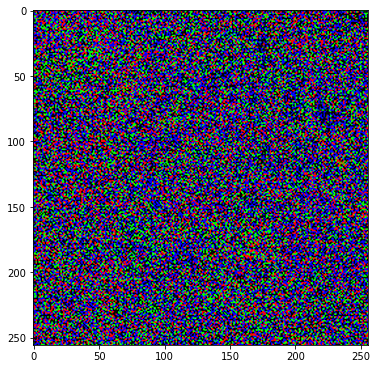

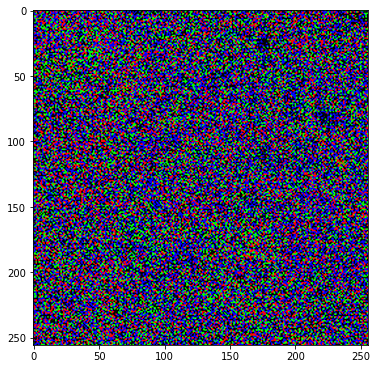

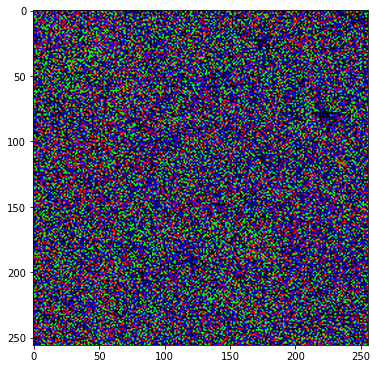

In [57]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

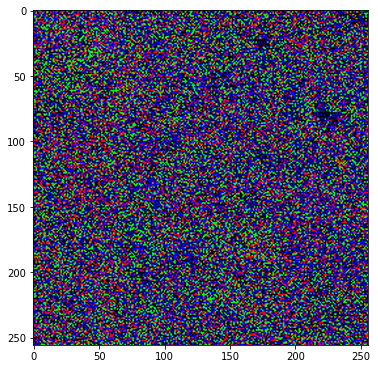

In [58]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [64]:
out_array = np.zeros((square, square), dtype=(np.uint8, 3))

for h in range(square):
    for w in range(square):
        channel = out_np[:, h, w].argmax()
        out_array[h, w, channel] = 255


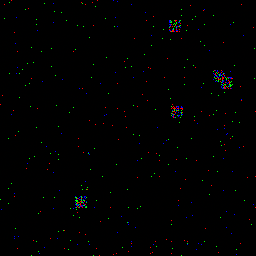

In [65]:
diff = array - out_array
new_image = Image.fromarray(diff)
new_image.save(out_file)
IPython.display.Image(out_file) 

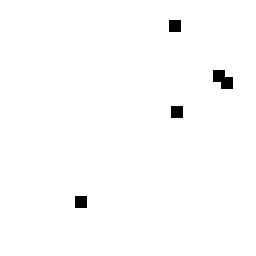

In [63]:
IPython.display.Image(mask_file)